##### Position and rotation estimation with pooling layers and RGB images
## Using rotations defined by RGB values

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import random
import math

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU

# Preparing data

In [2]:
DATADIR = "dataset_generator/images/pose10000/"
JSON_file_name = "data.txt"
IMAGES = 5_000
OG_IMG_SIZE = 800
IMG_SIZE = 150

In [3]:
data_json = []
for line in open(DATADIR + JSON_file_name, 'r'):
    data_json.append(json.loads(line))
    
dataset = [] # [x, y]

for img in os.listdir(DATADIR):
    if(img.endswith(".jpg")):
        img_array = cv2.imread(os.path.join(DATADIR, img))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        img_index = int(img.strip(".jpg"))
        for label in data_json:
            if(label['index'] == img_index):
                choosen_label = {'bx': label['bx'], 
                                 'by': label['by'], 
                                 'bw': label['bw'], 
                                 'bh': label['bh'], 
                                 'posX': label['posX'], 
                                 'posY': label['posY'], 
                                 'posZ': label['posZ'],
                                 'rx': label['rx'],
                                 'gx': label['gx'],
                                 'bxx': label['bxx'],
                                 'ry': label['ry'],
                                 'gy': label['gy'],
                                 'byy': label['byy'],
                                'rotX': label['rotX'],
                                'rotY': label['rotY']}
                
                xy = [img_array, choosen_label]
                dataset.append(xy)
                
        if(len(dataset)%500 ==0):
            print(f"{len(dataset)} images loaded")
        
        if(len(dataset) >= IMAGES):
            print("All images loaded")
            break
            
IMAGES = len(dataset)
print(f"{IMAGES} in total")

500 images loaded
1000 images loaded
1500 images loaded
2000 images loaded
2500 images loaded
3000 images loaded
3500 images loaded
4000 images loaded
4500 images loaded
5000 images loaded
All images loaded
5000 in total


# Creating training dataset

In [4]:
X = []
y = []

shuffled_indices = random.sample(range(0, IMAGES), IMAGES)

for i in shuffled_indices:
    
    pixels = dataset[i][0]
    pixels = pixels.astype('uint8')
    X.append(pixels)
    
    y_labels = [dataset[i][1]['bx'], 
                dataset[i][1]['by'], 
                dataset[i][1]['bw'], 
                dataset[i][1]['bh'], 
                dataset[i][1]['posX'], 
                dataset[i][1]['posY'], 
                dataset[i][1]['posZ'],
                dataset[i][1]['rx'],
                dataset[i][1]['gx'],
                dataset[i][1]['bxx'],
                dataset[i][1]['ry'],
                dataset[i][1]['gy'],
                dataset[i][1]['byy'],
               dataset[i][1]['rotX'],
               dataset[i][1]['rotY']]
    
    y.append(y_labels)

# Global Standardization
X = (np.array(X).reshape(IMAGES, IMG_SIZE, IMG_SIZE, 3) - np.mean(X)) / np.std(X)
    
for index, ya in enumerate(y):
    y[index] = np.array([ya[0]/100, 
                         ya[1]/100, 
                         ya[2]/100, 
                         ya[3]/100, 
                         ya[4]/10, 
                         ya[5]/10, 
                         ya[6]/10, 
                         ya[7]/255,
                         ya[8]/255,
                         ya[9]/255,
                         ya[10]/255,
                         ya[11]/255,
                         ya[12]/255])
    
y = np.array(y)

print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (5000, 150, 150, 3)
y shape: (5000, 13)


In [5]:
def RGBToAngle(rgb):
    angle = math.atan2(math.sqrt(3) * (rgb[1] - rgb[2]), 2 * rgb[0] - rgb[1] - rgb[2])
    if(angle < 0):
        angle += math.pi*2
    
    return math.degrees(angle)

In [6]:
def AngleToRGB(angle):
    X  = 1 - abs(angle/60%2-1)
    
    if(0 <= angle < 60):
        RPrim = 1
        GPrim = X
        BPrim = 0
    elif (60 <= angle < 120):
        RPrim = X
        GPrim = 1
        BPrim = 0
    elif (120 <= angle < 180):
        RPrim = 0
        GPrim = 1
        BPrim = X
    elif (180 <= angle < 240):
        RPrim = 0
        GPrim = X
        BPrim = 1
    elif (240 <= angle < 300):
        RPrim = X
        GPrim = 0
        BPrim = 1
    elif (300 <= angle < 360):
        RPrim = 1
        GPrim = 0
        BPrim = X
        
    return [RPrim*255, GPrim*255, BPrim*255]

In [7]:
degrees = []
for i in range(360):
    rgb = AngleToRGB(i)
    s = rgb[0]*0.33 + rgb[1]*0.33 + rgb[2]*0.33
    degrees.append([rgb[0], rgb[1], rgb[2], s])

# Relation of RGB components and degrees

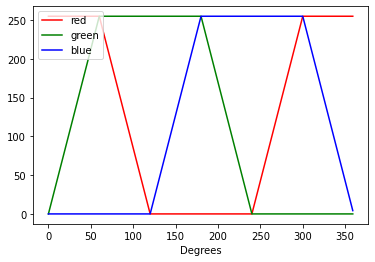

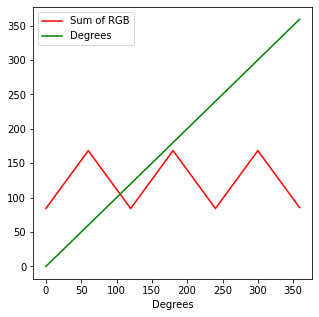

In [8]:
plt.plot([i for i in range(360)], [i[0] for i in degrees], color = "red", label = "red")
plt.plot([i for i in range(360)], [i[1] for i in degrees], color = "green", label = "green")
plt.plot([i for i in range(360)], [i[2] for i in degrees], color = "blue", label = "blue")
plt.xlabel("Degrees")
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(5, 5))
plt.plot([i for i in range(360)], [i[3] for i in degrees], color = "red", label = "Sum of RGB")
plt.plot([i for i in range(360)], [i for i in range(360)], color = "green", label = "Degrees")
plt.xlabel("Degrees")
plt.legend(loc='upper left')
plt.show()

# Dataset sample

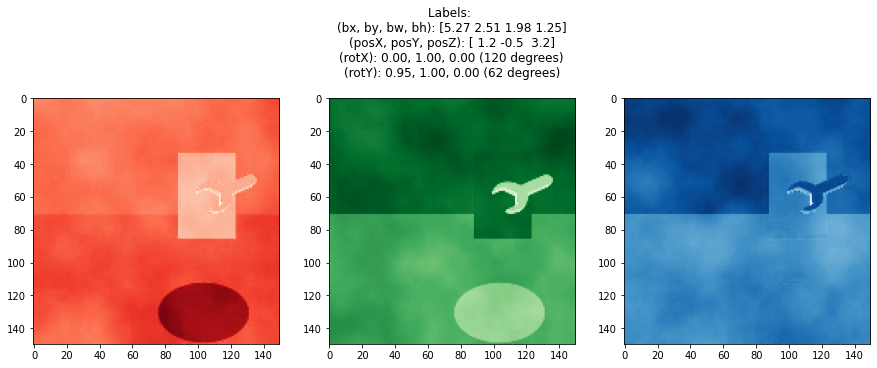

In [9]:
random_index = random.randrange(IMAGES)
fig, axs = plt.subplots(ncols = 3, figsize = (15, 15))

axs[0].imshow(X[random_index][:, :, 0], cmap="Reds")
axs[1].imshow(X[random_index][:, :, 1], cmap="Greens")
axs[2].imshow(X[random_index][:, :, 2], cmap="Blues")

title = "Labels: \n\
(bx, by, bw, bh): {frameLabels}\n\
(posX, posY, posZ): {positionLabels}\n\
(rotX): {rx:.2f}, {gx:.2f}, {bx:.2f} ({xDegrees1} degrees)\n\
(rotY): {ry:.2f}, {gy:.2f}, {by:.2f} ({yDegrees1} degrees)\n".format(frameLabels = y[random_index][:4],
                              positionLabels = y[random_index][4:7],
                              rx = y[random_index][7],
                              gx = y[random_index][8],
                              bx =y[random_index][9],
                              ry = y[random_index][10],
                              gy = y[random_index][11],
                              by = y[random_index][12],
                              xDegrees1 = int(RGBToAngle(y[random_index][7:10])),
                              yDegrees1 = int(RGBToAngle(y[random_index][10:13])))

axs[1].set_title(title)

plt.show()

# Model

### Custom accuracy metric

In [10]:
from tensorflow.math import add, subtract, multiply, divide, sqrt, atan2

def position_error_x(y_true, y_pred):
    error_sum = 0
    samples = len(y_true)
    for i in range(samples):
        error_sum += abs(y_true[i][0] - y_pred[i][0])
    return (error_sum * 10)/samples

def position_error_y(y_true, y_pred):
    error_sum = 0
    for i in range(len(y_true)):
        error_sum += abs(y_true[i][1] - y_pred[i][1])
    return (error_sum * 10)/len(y_true)

def position_error_z(y_true, y_pred):
    error_sum = 0
    for i in range(len(y_true)):
        error_sum += abs(y_true[i][2] - y_pred[i][2])
    return (error_sum * 10)/len(y_true)

def acc_20(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        angle_true = RGBToAngle(y_true[i])
        angle_pred = RGBToAngle(y_pred[i])
        
        if(abs(angle_true - angle_pred) < 20):
            count += 1
    return count / len(y_true)

def acc_15(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        angle_true = RGBToAngle(y_true[i])
        angle_pred = RGBToAngle(y_pred[i])
        
        if(abs(angle_true - angle_pred) < 15):
            count += 1
    return count / len(y_true)

def acc_10(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        angle_true = RGBToAngle(y_true[i])
        angle_pred = RGBToAngle(y_pred[i])
        
        if(abs(angle_true - angle_pred) < 10):
            count += 1
    return count / len(y_true)

def acc_5(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        angle_true = RGBToAngle(y_true[i])
        angle_pred = RGBToAngle(y_pred[i])
        
        if(abs(angle_true - angle_pred) < 5):
            count += 1
    return count / len(y_true)

def IoU(y_true, y_pred):
    mean = 0
    for i in range (len(y_true)):
        x1, y1, w1, h1 = y_true[i]
        x2, y2, w2, h2 = y_pred[i]
        
        w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
        h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
        
        if w_I <= 0 or h_I <= 0:  # no overlap
            continue
        else:
            I = w_I * h_I
            U = w1 * h1 + w2 * h2 - I
            mean += I / U
            
    mean /= len(y_true)
    return mean 

# Creating and training models with Adam and Adadelta optimizers

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
ps_conv_0 (Conv2D)              (None, 148, 148, 16) 448         Inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 148, 148, 16) 0           ps_conv_0[0][0]                  
__________________________________________________________________________________________________
ps_conv_1 (Conv2D)              (None, 146, 146, 32) 4640        leaky_re_lu_14[0][0]             
______________________________________________________________________________________________

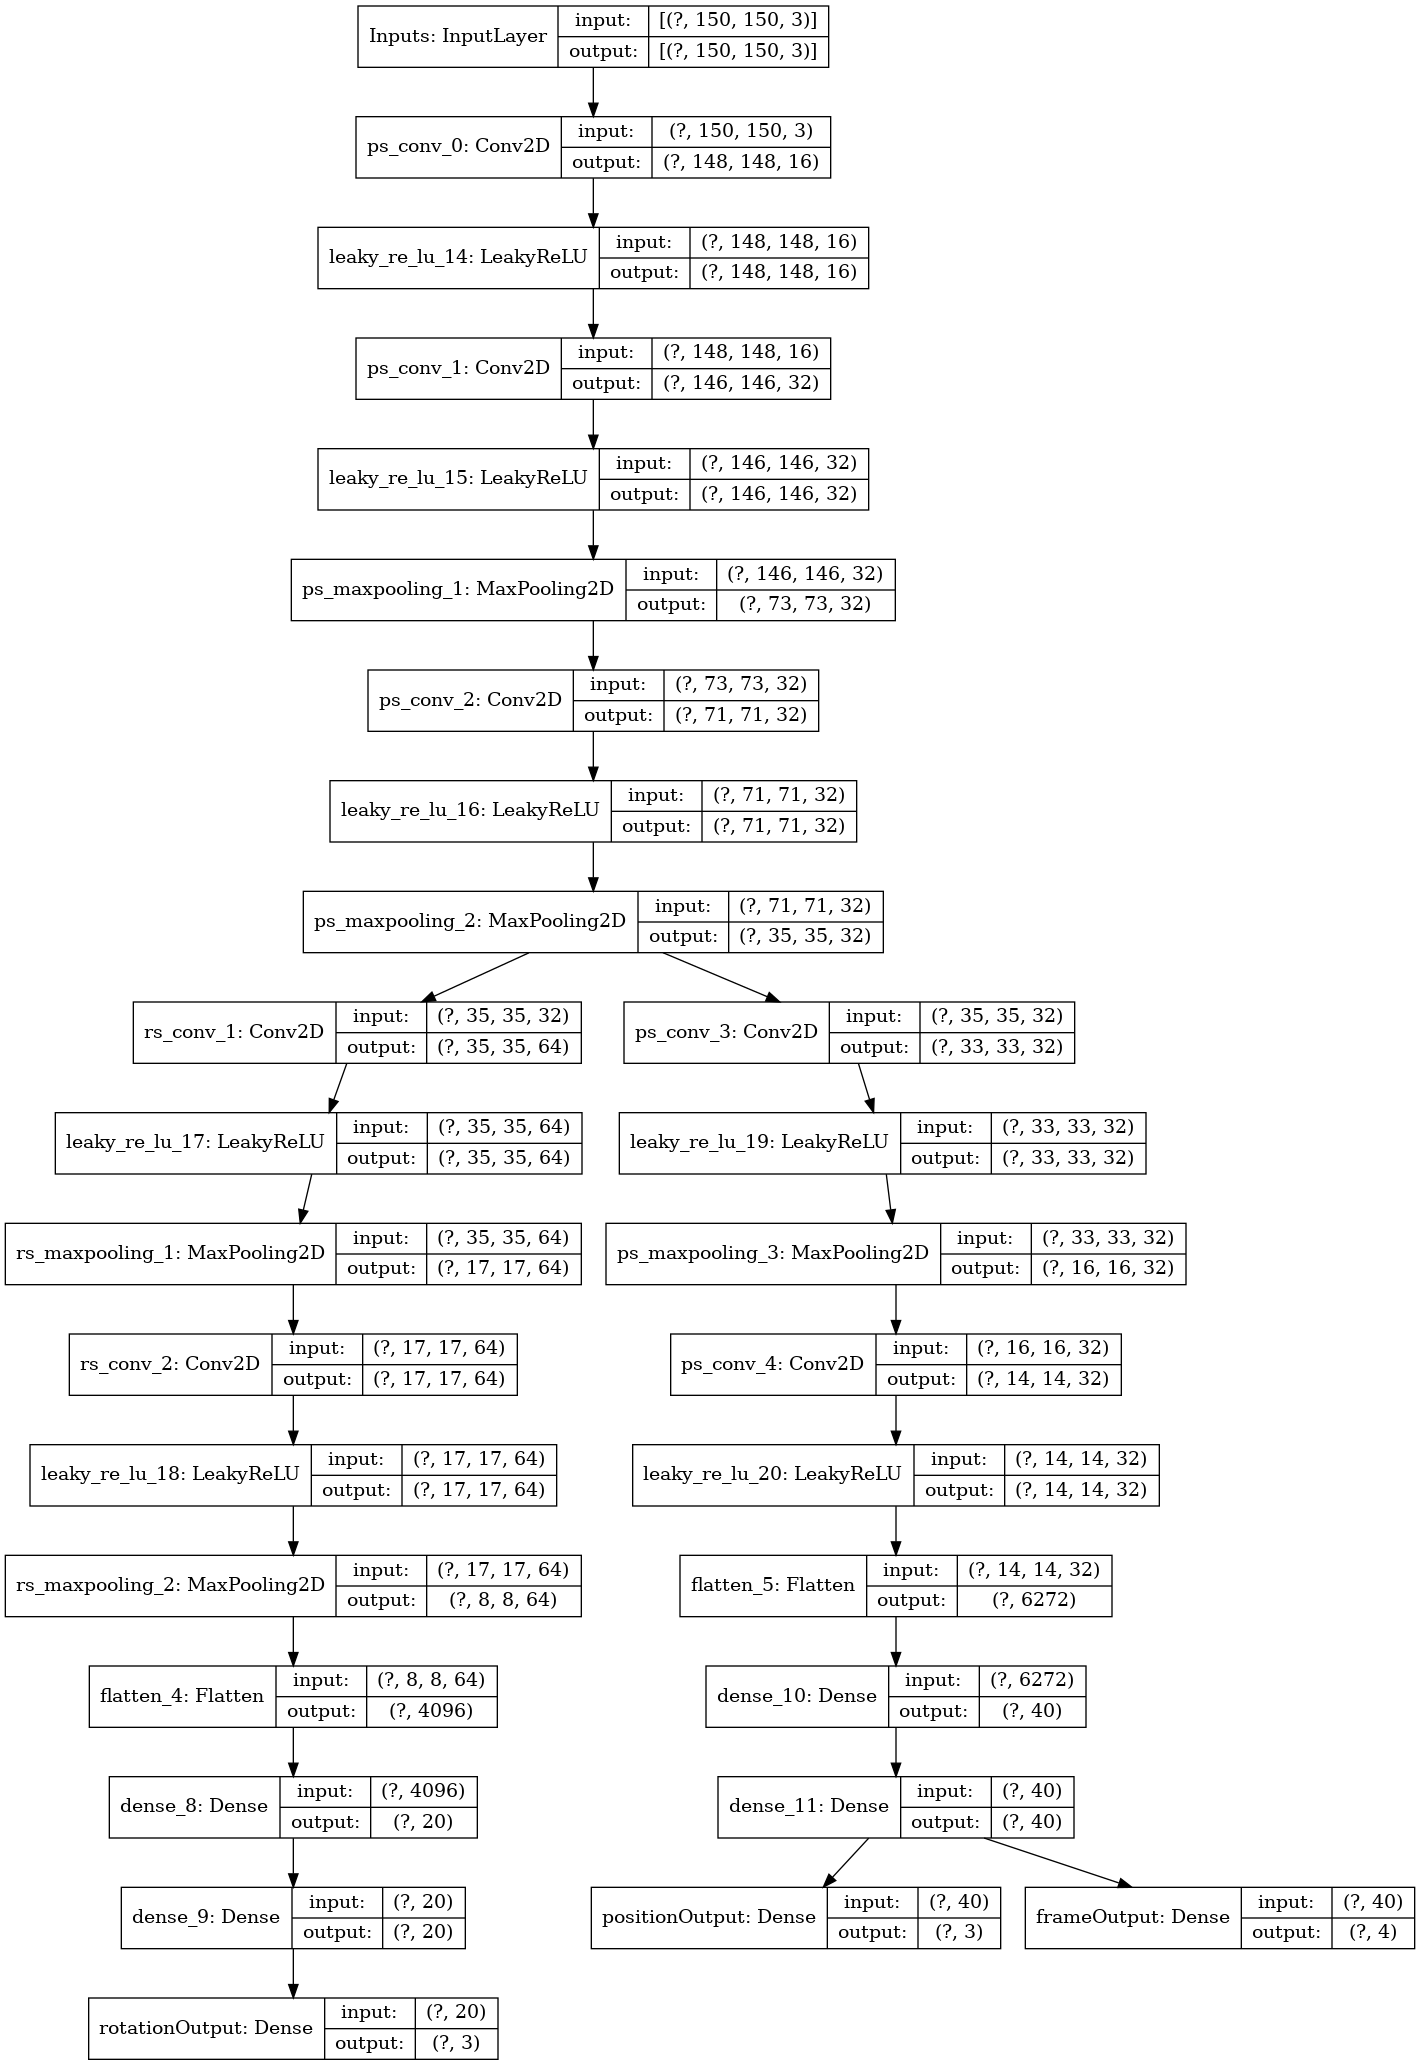

In [15]:
inputs = Input(name = "Inputs",
              shape = (IMG_SIZE, IMG_SIZE, 3))

# Main Stream
positionStream = Conv2D(name = "ps_conv_0",
                   filters = 16,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(inputs)

positionStream = LeakyReLU()(positionStream)

positionStream = Conv2D(name = "ps_conv_1",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = LeakyReLU()(positionStream)

positionStream = MaxPooling2D(name="ps_maxpooling_1", 
                          pool_size = (2, 2), 
                          strides = 2)(positionStream)

positionStream = Conv2D(name = "ps_conv_2",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = LeakyReLU()(positionStream)

positionStream = MaxPooling2D(name="ps_maxpooling_2", 
                          pool_size = (2, 2), 
                          strides = 2)(positionStream)

# ROTATION START

rotationStream = Conv2D(name = "rs_conv_1",
                   filters = 64,
                   kernel_size = 3,
                   strides = 1,
                   padding = "same",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

rotationStream = LeakyReLU()(rotationStream)

rotationStream = MaxPooling2D(name="rs_maxpooling_1", 
                          pool_size = (2, 2), 
                          strides = 2)(rotationStream)

rotationStream = Conv2D(name = "rs_conv_2",
                   filters = 64,
                   kernel_size = 3,
                   strides = 1,
                   padding = "same",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(rotationStream)

rotationStream = LeakyReLU()(rotationStream)

rotationStream = MaxPooling2D(name="rs_maxpooling_2", 
                          pool_size = (2, 2), 
                          strides = 2)(rotationStream)

rotationStream = Flatten()(rotationStream)

rotationStream = Dense(20, activation = "relu")(rotationStream)
rotationStream = Dense(20, activation = "relu")(rotationStream)

rotationStream = Dense(3, name = "rotationOutput")(rotationStream)

# ROTATION END

positionStream = Conv2D(name = "ps_conv_3",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = LeakyReLU()(positionStream)

positionStream = MaxPooling2D(name="ps_maxpooling_3", 
                          pool_size = (2, 2), 
                          strides = 2)(positionStream)

positionStream = Conv2D(name = "ps_conv_4",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = LeakyReLU()(positionStream)

positionStream = Flatten()(positionStream)

positionStream = Dense(40, activation = "relu")(positionStream)
positionStream = Dense(40, activation = "relu")(positionStream)

positionStreamOutput = Dense(3, name = "positionOutput")(positionStream)
frameStreamOutput = Dense(4, name = "frameOutput")(positionStream)


sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, 
                                        momentum=0.0, 
                                        nesterov=False)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, 
                                          beta_1=0.95, 
                                          amsgrad=True)
adadelta_optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, 
                                                  rho=0.95)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, 
                                                rho=0.9, 
                                                momentum=0.0, 
                                                centered=False)

model1 = keras.Model(inputs,[positionStreamOutput, rotationStream, frameStreamOutput], name = "Model")
model1.compile(optimizer = adam_optimizer,
             loss = {"positionOutput": tf.keras.losses.MeanSquaredError(), 
                     "rotationOutput": tf.keras.losses.MeanSquaredError(), 
                     "frameOutput": tf.keras.losses.MeanSquaredError()},

             metrics = {"positionOutput": [position_error_x, 
                                           position_error_y, 
                                           position_error_z], 
                        "rotationOutput": [acc_20, 
                                           acc_15, 
                                           acc_10, 
                                           acc_5],
                        "frameOutput": [IoU]},
             run_eagerly=True)

model2 = keras.Model(inputs,[positionStreamOutput, rotationStream, frameStreamOutput], name = "Model")
model2.compile(optimizer = adadelta_optimizer,
             loss = {"positionOutput": tf.keras.losses.MeanSquaredError(), 
                     "rotationOutput": tf.keras.losses.MeanSquaredError(), 
                     "frameOutput": tf.keras.losses.MeanSquaredError()},

             metrics = {"positionOutput": [position_error_x, 
                                           position_error_y, 
                                           position_error_z], 
                        "rotationOutput": [acc_20, 
                                           acc_15, 
                                           acc_10, 
                                           acc_5],
                        "frameOutput": [IoU]},
             run_eagerly=True)

models = [model1, model2]
histories = []

training_data_x = X[:int(IMAGES*0.9)]
training_data_y = y[:int(IMAGES*0.9)]
validation_data_x = X[int(IMAGES*0.9):IMAGES]
validation_data_y = y[int(IMAGES*0.9):IMAGES]

for model in models:
    history = model.fit(x = training_data_x,
                        y = {"positionOutput": training_data_y[:, 4:7], "rotationOutput": training_data_y[:, 10:13], "frameOutput": training_data_y[:, 0:4]},
                        validation_data = (validation_data_x, {"positionOutput": validation_data_y[:, 4:7], "rotationOutput": validation_data_y[:, 10:13], "frameOutput": validation_data_y[:, 0:4]}),
                        batch_size = 32,
                        epochs = 12,
                        verbose = 0)
    
    histories.append(history)

model2.summary()
keras.utils.plot_model(model2, "model.png", show_shapes=True)

# Training

adam


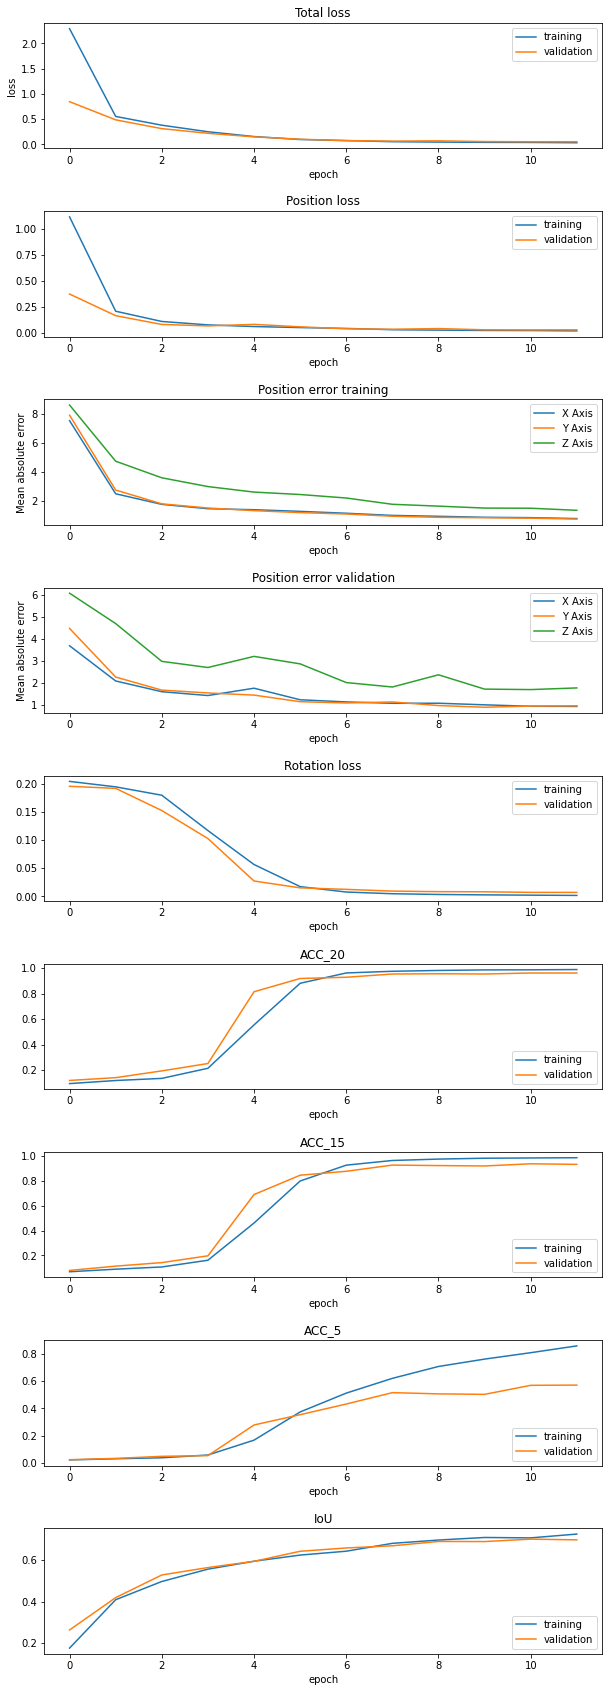

adadelta


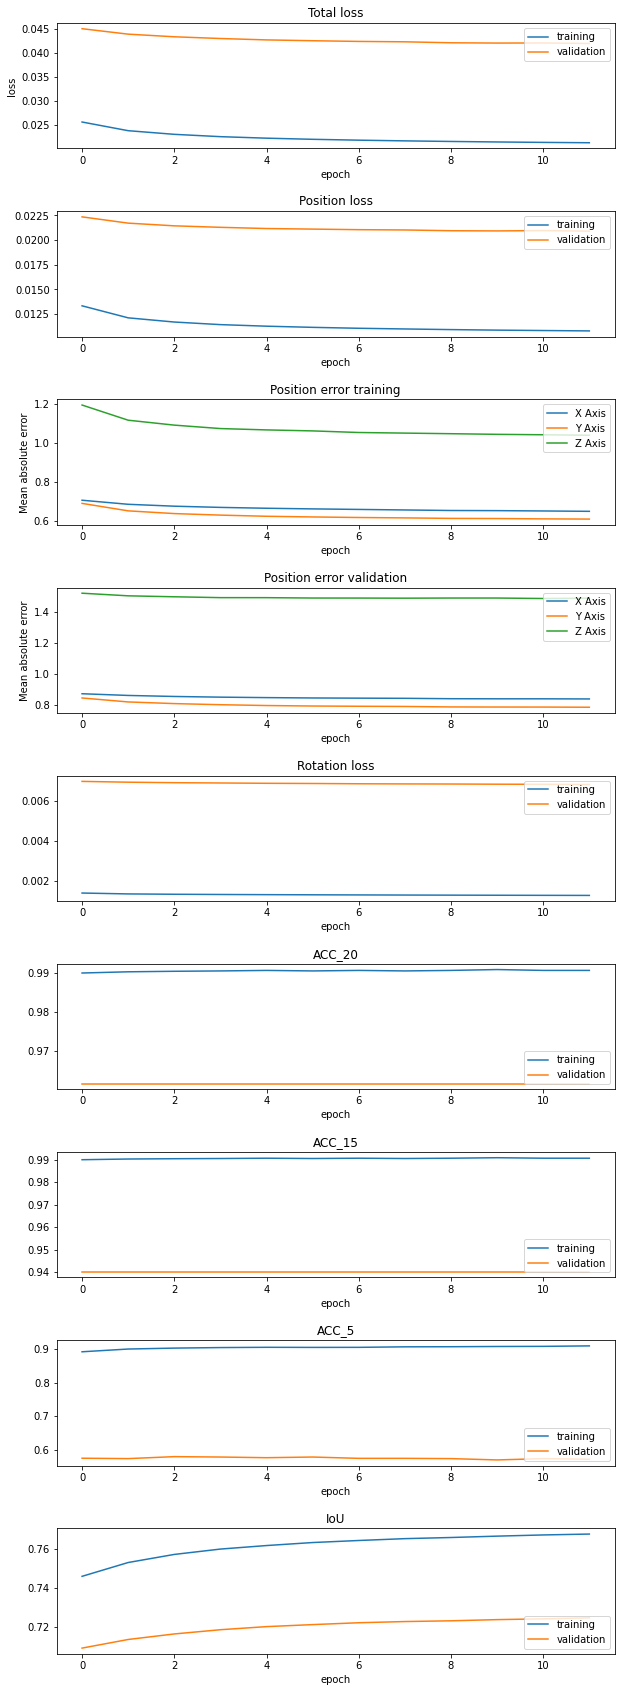

In [16]:
optimizers_names = ["adam", "adadelta"]
for name, history in zip(optimizers_names, histories):
    fig, axs = plt.subplots(ncols = 1, nrows = 9, figsize=(10,30))
    print(name)

    axs[0].plot(history.history['loss'], label = "training")
    axs[0].plot(history.history['val_loss'], label = "validation")
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Total loss")

    axs[1].plot(history.history['positionOutput_loss'], label = "training")
    axs[1].plot(history.history['val_positionOutput_loss'], label = "validation")
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper right')
    axs[1].set_title("Position loss")

    axs[2].plot(history.history['positionOutput_position_error_x'], label = "X Axis")
    axs[2].plot(history.history['positionOutput_position_error_y'], label = "Y Axis")
    axs[2].plot(history.history['positionOutput_position_error_z'], label = "Z Axis")
    axs[2].set_ylabel('Mean absolute error')
    axs[2].set_xlabel('epoch')
    axs[2].legend(loc='upper right')
    axs[2].set_title("Position error training")

    axs[3].plot(history.history['val_positionOutput_position_error_x'], label = "X Axis")
    axs[3].plot(history.history['val_positionOutput_position_error_y'], label = "Y Axis")
    axs[3].plot(history.history['val_positionOutput_position_error_z'], label = "Z Axis")
    axs[3].set_ylabel('Mean absolute error')
    axs[3].set_xlabel('epoch')
    axs[3].legend(loc='upper right')
    axs[3].set_title("Position error validation")

    axs[4].plot(history.history['rotationOutput_loss'], label = "training")
    axs[4].plot(history.history['val_rotationOutput_loss'], label = "validation")
    axs[4].set_xlabel('epoch')
    axs[4].legend(loc='upper right')
    axs[4].set_title("Rotation loss")

    axs[5].plot(history.history['rotationOutput_acc_20'], label = "training")
    axs[5].plot(history.history['val_rotationOutput_acc_20'], label = "validation")
    axs[5].set_xlabel('epoch')
    axs[5].legend(loc='lower right')
    axs[5].set_title("ACC_20")

    axs[6].plot(history.history['rotationOutput_acc_15'], label = "training")
    axs[6].plot(history.history['val_rotationOutput_acc_15'], label = "validation")
    axs[6].set_xlabel('epoch')
    axs[6].legend(loc='lower right')
    axs[6].set_title("ACC_15")

    axs[7].plot(history.history['rotationOutput_acc_5'], label = "training")
    axs[7].plot(history.history['val_rotationOutput_acc_5'], label = "validation")
    axs[7].set_xlabel('epoch')
    axs[7].legend(loc='lower right')
    axs[7].set_title("ACC_5")

    axs[8].plot(history.history['frameOutput_IoU'], label = "training")
    axs[8].plot(history.history['val_frameOutput_IoU'], label = "validation")
    axs[8].set_xlabel('epoch')
    axs[8].legend(loc='lower right')
    axs[8].set_title("IoU")

    plt.subplots_adjust(hspace=0.5)
    plt.show()


# Adadelta loss

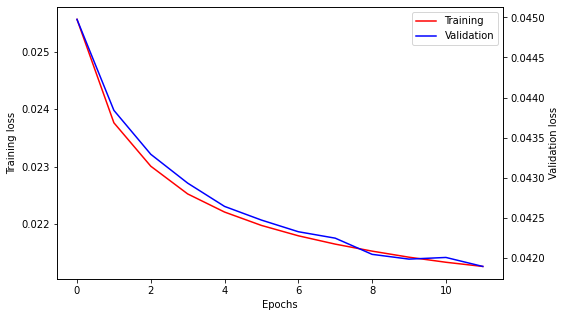

In [17]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

lns1 = ax.plot(histories[1].history["loss"], label = 'Training', color="red")
ax2 = ax.twinx()
lns3 = ax2.plot(histories[1].history["val_loss"], label = 'Validation', color="blue")

lns = lns1+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel("Epochs")
ax.set_ylabel("Training loss")
ax2.set_ylabel("Validation loss")
plt.show()

## Save successful model

In [50]:
model2.save("predictor/adadeltaModel")

# Error per axis

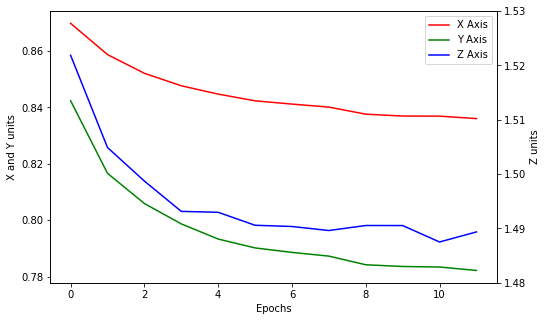

In [28]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

lns1 = ax.plot(histories[1].history["val_positionOutput_position_error_x"], label = 'X Axis', color="red")
lns2 = ax.plot(histories[1].history["val_positionOutput_position_error_y"], label = 'Y Axis', color="green")

ax2 = ax.twinx()
lns3 = ax2.plot(histories[1].history["val_positionOutput_position_error_z"], label = 'Z Axis', color="blue")

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel("Epochs")
ax.set_ylabel("X and Y units")
# ax.set_ylim([1, 1.15])
ax2.set_ylabel("Z units")
ax2.set_ylim([1.48, 1.53])
plt.show()

In [29]:
prediction = model2.predict(validation_data_x)

# Z axis error per distance from camera

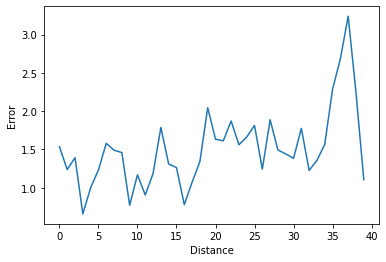

In [30]:
data_1 = [[] for i in range(40)]

for pred, true in zip(prediction[0], validation_data_y[:, 4:7]):
    error = abs(true[2] - pred[2]) * 10
    dist = 39 - true[2] * 10
    data_1[int(dist)].append(error)
    
data_2 = [sum(k)/len(k) for k in data_1]
plt.plot(data_2)
plt.xlabel("Distance")
plt.ylabel("Error")
plt.show()

# Probability of angle error per value

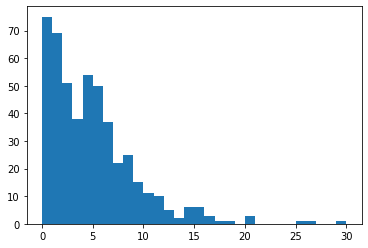

In [32]:
data_3 = []

for pred, true in zip(prediction[1], validation_data_y[:, 10:13]):
    error = abs(RGBToAngle(pred) - RGBToAngle(true))
    if(error < 30):
        data_3.append(error)

# plt.hist(data_3)
plt.hist(data_3, bins=np.arange(min(data_3), max(data_3) + 1, 1))
plt.show()

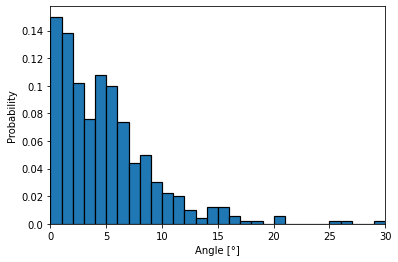

In [33]:
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 500)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

plt.gca().yaxis.set_major_formatter(yfmt)
plt.hist(data_3, bins=np.arange(min(data_3), max(data_3) + 1, 1), edgecolor='black', linewidth=1.2)
plt.xlabel("Angle [°]")
plt.ylabel("Probability")
plt.xlim([0, 30])
plt.show()
# final step
# plt.savefig("Output.pdf", dpi=400, bbox_inches='tight', pad_inches=1)

## Average rotation estimation error

In [34]:
meanRotError = sum(data_3) / len(data_3)
print(meanRotError)

4.911933671720707


# Probability of IoU value

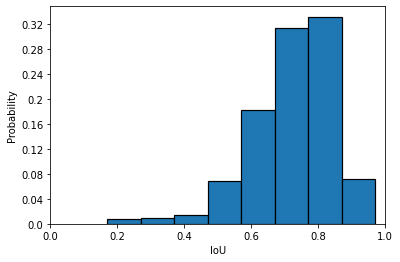

In [35]:
data_4 = []

for pred, true in zip(prediction[2], validation_data_y[:, 0:4]):
    value = IoU([list(true)], [list(pred)])
    data_4.append(value)

plt.gca().yaxis.set_major_formatter(yfmt)
plt.hist(data_4, bins=np.arange(min(data_4), max(data_4) + 0.1, 0.1), edgecolor='black', linewidth=1.2)
plt.xlabel("IoU")
plt.ylabel("Probability")
plt.xlim([0, 1])
plt.show()

## Average IoU value

In [36]:
meanIoU = sum(data_4) / len(data_4)
print(meanIoU)

0.7251321103949601


# ACC values

In [37]:
acc_20 = histories[1].history["val_rotationOutput_acc_20"][-1]
acc_15 = histories[1].history["val_rotationOutput_acc_15"][-1]
acc_10 = histories[1].history["val_rotationOutput_acc_10"][-1]
acc_5 = histories[1].history["val_rotationOutput_acc_5"][-1]

print(f"acc_20: {acc_20}\nacc_15: {acc_15}\nacc_10: {acc_10}\nacc_5: {acc_5}")

acc_20: 0.961718738079071
acc_15: 0.940234363079071
acc_10: 0.8726562261581421
acc_5: 0.572265625


# Sample results

In [38]:
model = model2

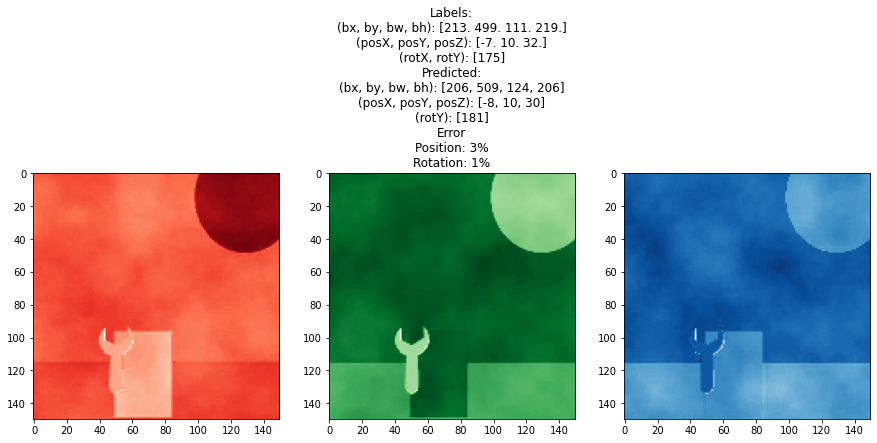

In [42]:
# random_index = random.randrange(len(training_data))
# Images from trainig set
# random_index = random.randrange(IMAGES*0.8)

# Images from validation set
random_index = random.randrange(IMAGES*0.9 ,IMAGES)

prediction = model.predict(X[random_index].reshape(1, IMG_SIZE, IMG_SIZE, 3))

fig, axs = plt.subplots(ncols = 3, figsize = (15, 15))

axs[0].imshow(X[random_index][:, :, 0], cmap="Reds")
axs[1].imshow(X[random_index][:, :, 1], cmap="Greens")
axs[2].imshow(X[random_index][:, :, 2], cmap="Blues")

frame_og = y[random_index][:4]*100
pos_og = y[random_index][4:7]*10
rot_og = [int(RGBToAngle(y[random_index][10:13]))]

frame_pred = [int(p*100) for p in prediction[2][0]]
pos_pred = [int(p*10) for p in prediction[0][0]]
rot_pred = [int(RGBToAngle(prediction[1][0][0:3]))]

pos_error = int(sum((abs(pos_pred-pos_og)/30)*100)/3)
rot_error = int(abs((rot_pred[0]-rot_og[0])/360)*100)

axs[1].set_title(f"Labels:\
\n(bx, by, bw, bh): {frame_og}\
\n(posX, posY, posZ): {pos_og}\
\n(rotX, rotY): {rot_og}\n\
Predicted:\
\n(bx, by, bw, bh): {frame_pred}\
\n(posX, posY, posZ): {pos_pred}\
\n(rotY): {rot_pred}\
\nError\
\nPosition: {pos_error}%\
\nRotation: {rot_error}%")

plt.show()

# Layer output extraction

### All layers and outputs

In [45]:
def extract_layer_data(layer):
    submodel = keras.Model(inputs = model.input, outputs = layer.output)
    submodel_output = submodel.predict(np.array(X[random_index]).reshape(1, IMG_SIZE, IMG_SIZE, 3))
    output_shape = submodel_output.shape
    
    graph_size = 10
    
    index = 0
    if (len(output_shape) != 2):
        if(output_shape[-1]>=4):
            fig, axs = plt.subplots(4, int(output_shape[-1]/4), figsize=(graph_size, graph_size))
            fig.suptitle(f"{layer.name}, [{output_shape}]")
            for col in range(0, 4):
                for row in range(0, int(output_shape[-1]/4)):
                    axs[col, row].imshow(submodel_output[0, :, :, index], cmap="Greys")
                    index += 1
                    axs[col, row].axis('off')
            
        else:
            fig, axs = plt.subplots(ncols = output_shape[-1], figsize=(graph_size, graph_size))
            for col in range(0, output_shape[-1]):
                axs[col].imshow(submodel_output[0, :, :, index], cmap="Greys")
                if(int(output_shape[-1]/2) == col):
                    axs[col].set_title(f"{layer.name}, [{output_shape}]")
                index += 1
                axs[col].axis('off')
    plt.tight_layout()
    
# for layer in model.layers:
#     extract_layer_data(layer)

### Specified layer and number of outputs

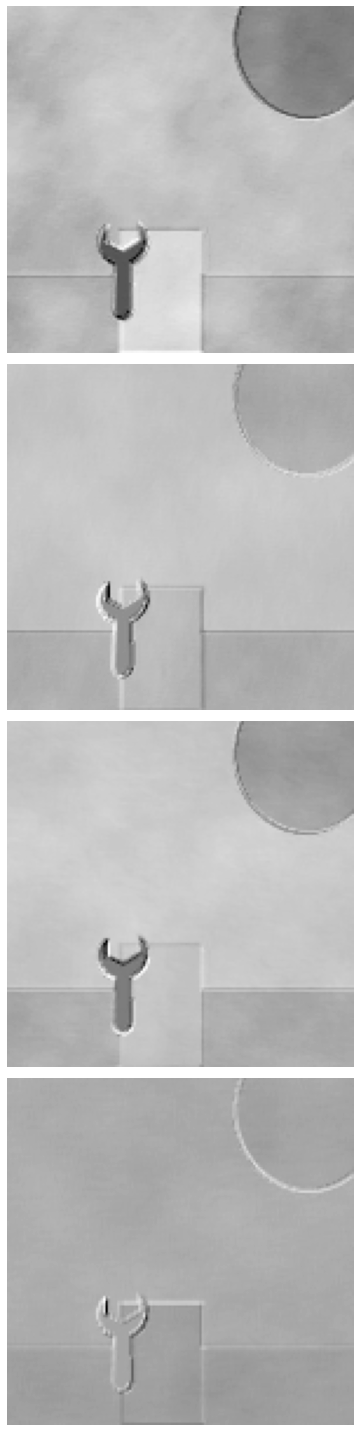

In [46]:
def extract_layer_data(layer):
    submodel = keras.Model(inputs = model.input, outputs = layer.output)
    submodel_output = submodel.predict(np.array(X[random_index]).reshape(1, IMG_SIZE, IMG_SIZE, 3))
    output_shape = submodel_output.shape
    
    graph_size = 20
    number_of_outputs = 4
    
    index = 0
    if (len(output_shape) != 2):
        fig, axs = plt.subplots(number_of_outputs, figsize=(graph_size, graph_size))
        for col in range(0, number_of_outputs):
            axs[col].imshow(submodel_output[0, :, :, index], cmap="Greys")
            index += 1
            axs[col].axis('off')
            
    plt.tight_layout()
    
for layer in model.layers:
    if(layer.name == "ps_conv_0"):
        extract_layer_data(layer)

In [47]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

In [48]:
plt.rcParams.update({'font.size': 10})